In [1]:
from symred.projection import (
    S3_projection, QubitTapering, CS_VQE_LW, CS_VQE,
    StabilizerIdentification, ObservableBiasing, stabilizer_walk
)
from symred.symplectic import *
from symred.utils import exact_gs_energy
from symred.utils import gf2_gaus_elim, gf2_basis_for_gf2_rref
from symred.chem import geometry_from_pubchem, MoleculeBuilder
from matplotlib import pyplot as plt
from functools import reduce
import json

In [2]:
with open('data/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)
#with open('data/score_data.json', 'r') as infile:
#    scoring_data = json.load(infile)
print(molecule_geometries.keys())

dict_keys(['H2_3-21G_SINGLET', 'H6_STO-3G_SINGLET', 'H2_6-31G_SINGLET', 'H2_6-311G_SINGLET', 'H3+_STO-3G_SINGLET', 'H3+_3-21G_SINGLET', 'HeH+_3-21G_SINGLET', 'HeH+_6-311G_SINGLET', 'H2O_STO-3G_SINGLET', 'BeH+_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'CH+_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'B+_STO-3G_SINGLET', 'B_STO-3G_DOUBLET', 'N_STO-3G_QUARTET', 'OH-_STO-3G_SINGLET', 'O_STO-3G_TRIPLET', 'CH2_STO-3G_TRIPLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'C_STO-3G_TRIPLET', 'NH_STO-3G_SINGLET', 'Ne_STO-3G_SINGLET', 'F_STO-3G_DOUBLET', 'Li_STO-3G_DOUBLET', 'BH_STO-3G_SINGLET', 'NeH+_STO-3G_SINGLET', 'NH2-_STO-3G_SINGLET', 'BH3_STO-3G_SINGLET', 'BH2+_STO-3G_SINGLET', 'HCl_STO-3G_SINGLET', 'H4_STO-3G_SINGLET', 'NH3_STO-3G_SINGLET', 'F2_STO-3G_SINGLET', 'HCN_STO-3G_SINGLET', 'CH4_STO-3G_SINGLET', 'CH3NHCH3_STO-3G_SINGLET', 'CH3CH2NH2_STO-3G_SINGLET', 'CH3CH2OH_STO-3G_SINGLET', 'CH3OH_STO-3G_SINGLET', 'C2H6_STO-3G_SINGLET', 'CH3CN_STO-3G_SINGLET', 'CH3CHO_STO-3G_SINGLET', 'CH3CHOHCH3_STO-3

# Build the molecule and its Hamiltonian with the Coupled-Cluster operator 

In [3]:
# Set molecule parameters
speciesname = 'H4_STO-3G_SINGLET'
#print(speciesname in scoring_data)
mol_data = molecule_geometries[speciesname]
if 'name' in mol_data:
    print(mol_data['name'])
    
atoms  = mol_data['atoms']
coords = mol_data['coords']
basis  = 'sto-3g' #'cc-pVDZ' #mol_data['basis'] #'6-31g' #'cc-pVDZ' #
spin   = 0#mol_data['multiplicity']
charge = mol_data['charge']
geometry = list(zip(atoms, coords))
molecule = MoleculeBuilder(geometry=geometry, charge=charge, basis=basis, spin=spin, run_fci=True)

Molecule geometry:
H	0.0	0.0	0.0
H	1.0	0.0	0.0
H	0.0	1.0	0.0
H	1.0	1.0	0.0

HF converged?   True
CCSD converged? True
FCI converged?  True

HF energy:   -1.6948900044002917
MP2 energy:  -1.7210582091679236
CCSD energy: -1.7509178296479513
FCI energy:  -1.915106549511803


Number of qubits: 8


In [9]:
from symred.symplectic import array_to_QuantumState

print(array_to_QuantumState(exact_gs_energy(molecule.H_q.to_sparse_matrix)[1]))

-0.0001125386+0.0000040040j |00001111> +
 0.0446588396-0.0015888946j |00011011> +
-0.0446588396+0.0015888946j |00100111> +
-0.0000000000-0.0000000000j |00101011> +
 0.0001125386-0.0000040040j |00110011> +
-0.0000313986+0.0000011171j |01001110> +
 0.0000000000+0.0000000000j |01011001> +
-0.0481978287+0.0017148065j |01011010> +
-0.0000000000-0.0000000000j |01100101> +
-0.0731177298+0.0026014192j |01100110> +
 0.1213155585-0.0043162257j |01101001> +
-0.0000000000-0.0000000000j |01101010> +
 0.0000313986-0.0000011171j |01110010> +
 0.0000313986-0.0000011171j |10001101> +
 0.1213155585-0.0043162257j |10010110> +
-0.0731177298+0.0026014192j |10011001> +
 0.0000000000+0.0000000000j |10011010> +
-0.0481978287+0.0017148065j |10100101> +
-0.0000000000-0.0000000000j |10100110> +
 0.0000000000+0.0000000000j |10101001> +
-0.0000313986+0.0000011171j |10110001> +
 0.0017367350-0.0000617904j |11001100> +
 0.0000000000+0.0000000000j |11010100> +
-0.6891906446+0.0245203702j |11011000> +
 0.6891906446-0.

In [110]:
28 * 6 + 10 * 6 #benzene cc-vPDZ basis

228

Molecular orbital energies:


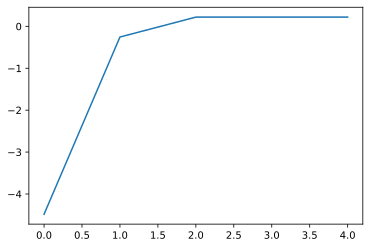

In [111]:
print('Molecular orbital energies:')
plt.plot(molecule.pyscf_obj.pyscf_hf.mo_energy)
plt.show()

# Taper the Hamiltonian

In [112]:
taper_hamiltonian = QubitTapering(molecule.H_q)

print(f'We are able to taper {taper_hamiltonian.n_taper} qubits from the Hamiltonian.\n')
print('The symmetry generators are\n')
print(taper_hamiltonian.symmetry_generators)
print('\nand may be rotated via a sequence of Clifford pi/2 rotations\n')
print(taper_hamiltonian.stabilizers.stabilizer_rotations)
print('\nonto the single-qubit Pauli operators\n')
print(taper_hamiltonian.stabilizers.rotate_onto_single_qubit_paulis())
hf_array = molecule.H_fermion.hf_comp_basis_state
taper_hamiltonian.stabilizers.update_sector(hf_array)
print(f'\nThe symetry sector corresponding with the reference {hf_array} is {taper_hamiltonian.stabilizers.coeff_vec}')
ham_tap = taper_hamiltonian.taper_it(ref_state=hf_array)
sor_tap = taper_hamiltonian.taper_it(aux_operator=molecule.SOR_q, ref_state=hf_array)
#sor_tap.coeff_vec/=np.linalg.norm(sor_tap.coeff_vec)
ucc_tap = taper_hamiltonian.taper_it(aux_operator=molecule.T_q, ref_state=hf_array)
n_taper = taper_hamiltonian.n_taper
tapered_qubits   = taper_hamiltonian.stab_qubit_indices
untapered_qubits = taper_hamiltonian.free_qubit_indices
hf_tapered = taper_hamiltonian.tapered_ref_state

print(f'The tapered Hartree-Fock state is', QuantumState([hf_tapered]))

We are able to taper 5 qubits from the Hamiltonian.

The symmetry generators are

 1 ZIZIIZIZIZ 
 1 IZIZIZIZIZ 
 1 IIIIZZIIII 
 1 IIIIIIZZII 
 1 IIIIIIIIZZ

and may be rotated via a sequence of Clifford pi/2 rotations

None

onto the single-qubit Pauli operators

-1 XIIIIIIIII 
-1 IXIIIIIIII 
-1 IIIIXIIIII 
-1 IIIIIIXIII 
-1 IIIIIIIIXI

The symetry sector corresponding with the reference [1 1 1 1 0 0 0 0 0 0] is [1 1 1 1 1]
The tapered Hartree-Fock state is  1.0000000000 |11000>


# Build the CS-VQE model

In [113]:
cs_vqe = CS_VQE(ham_tap, hf_tapered, basis_weighting_operator=ucc_tap, noncontextual_form='diag')

# Identify stabilizers according to the CC operator

In [118]:
def get_score_vs_error(S, max_sim_q=15):
    stab_score  = cs_vqe.basis_score(S)
    ham_cs = cs_vqe.project_onto_subspace(S, enforce_clique_operator=False)
    n_qubits = ham_cs.n_qubits
    if i<=max_sim_q:
        matrix = ham_cs.to_sparse_matrix
        energy = exact_gs_energy(matrix)[0]
        error  = energy-molecule.fci_energy
    else:
        error = None
    
    return stab_score, error
    
ham_stabilizers = StabilizerIdentification(ham_tap)
CC_stabilizers  = StabilizerIdentification(ucc_tap)
#HL_gap = np.where(hf_array==0)[0][0]-.5
HL_gap = np.where(hf_tapered==0)[0][0]-.5
#ham_biasing = ObservableBiasing(base_operator=molecule.H_q, HOMO_LUMO_gap=HL_gap)
ham_biasing = ObservableBiasing(base_operator=ham_tap, HOMO_LUMO_gap=HL_gap)

scores = []

for i in range(1, ham_tap.n_qubits):
    print(i)
    # by ham
    S_ham = ham_stabilizers.symmetry_basis_by_subspace_dimension(i)
    stab_score_ham, error_ham = get_score_vs_error(S_ham)

    # by CC
    S_CC = CC_stabilizers.symmetry_basis_by_subspace_dimension(i)
    stab_score_CC, error_CC = get_score_vs_error(S_CC)
    
    # by HOMO-LUMO biasing
    S_HL = stabilizer_walk(
            n_sim_qubits=i, 
            biasing_operator=ham_biasing, 
            cs_vqe_object=cs_vqe,
            #tapering_object=taper_hamiltonian,
            #reference_state=hf_array
        )
    stab_score_HL, error_HL = get_score_vs_error(S_HL)
    
    scores.append((i, stab_score_ham, error_ham, stab_score_CC, error_CC, stab_score_HL, error_HL))

1
2
3
4


In [115]:
import sys
sys.path.append( '../../CS-VQE' )
from utils.cs_vqe_tools_original import *

In [116]:
H = ham_tap.to_dictionary
H_noncon = greedy_dfs(H, cutoff=1)[-1]
H_noncon = {P:H[P] for P in H_noncon}
nc_legacy, energies_legacy, errors_legacy, order_legacy = csvqe_approximations_heuristic(
    H, H_noncon, ham_tap.n_qubits, molecule.fci_energy)

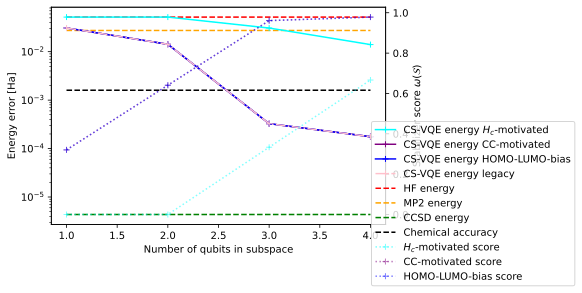

In [119]:
fig,energy_axis = plt.subplots()
X, Y_ham, Y_error_ham, Y_CC, Y_error_CC, Y_HL, Y_error_HL = zip(*scores)

energy_axis.plot(X, Y_error_ham, color='cyan', marker='+', label='CS-VQE energy $H_c$-motivated')
energy_axis.plot(X, Y_error_CC, color='purple', marker='+', label='CS-VQE energy CC-motivated')
energy_axis.plot(X, Y_error_HL, color='blue', marker='+', label='CS-VQE energy HOMO-LUMO-bias')
energy_axis.plot(X, errors_legacy[1:-1], color='pink', marker='+', label='CS-VQE energy legacy', ls='-.')

energy_axis.hlines(molecule.hf_energy-molecule.fci_energy, 1, X[-1], ls='--', color='red', label='HF energy')
energy_axis.hlines(molecule.mp2_energy-molecule.fci_energy, 1, X[-1], ls='--', color='orange', label='MP2 energy')
energy_axis.hlines(molecule.ccsd_energy-molecule.fci_energy, 1, X[-1], ls='--', color='green', label='CCSD energy')
energy_axis.hlines(0.0016, 1, X[-1], ls='--', color='black', label='Chemical accuracy')

energy_axis.set_yscale('log')
energy_axis.set_ylabel('Energy error [Ha]')
energy_axis.set_xlabel('Number of qubits in subspace')

score_axis = energy_axis.twinx()
score_axis.plot(X, Y_ham, color='cyan', label='$H_c$-motivated score', marker='+', alpha=0.5, ls=':')
score_axis.plot(X, Y_CC, color='purple', label='CC-motivated score', marker='+', alpha=0.5, ls=':')
score_axis.plot(X, Y_HL, color='blue', label='HOMO-LUMO-bias score', marker='+', alpha=0.5, ls=':')

score_axis.set_ylabel('Stabilizer score $\omega(\mathcal{S})$')

fig.legend(ncol=1, bbox_to_anchor=(1.35,0.5))
plt.show()

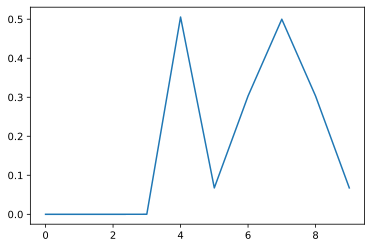

In [106]:
ham_biasing.HOMO_bias = 1
ham_biasing.LUMO_bias = 0.5
ham_biasing.separation =2
plt.plot(ham_biasing.HOMO_LUMO_bias_curve())

# Bias the Hamiltonian around the HOMO-LUMO gap

The HOMO-LUMO gap lies between spin-orbitals 15 and 16


<BarContainer object of 20 artists>

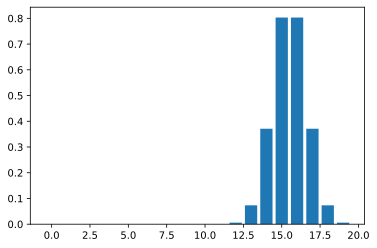

In [29]:
HL_gap = np.where(hf_array==0)[0][0]-.5
ham_biasing = ObservableBiasing(base_operator=molecule.H_q, HOMO_LUMO_gap=HL_gap)
CC_biasing  = ObservableBiasing(base_operator=molecule.T_q, HOMO_LUMO_gap=HL_gap)

ham_biasing.HOMO_bias  = 0.5
ham_biasing.LUMO_bias  = 0.5
ham_biasing.separation = 1

print(f'The HOMO-LUMO gap lies between spin-orbitals {int(HL_gap-1/2)} and {int(HL_gap+1/2)}')
plt.bar(np.arange(molecule.n_qubits),ham_biasing.HOMO_LUMO_bias_curve())

The HOMO-LUMO gap lies between spin-orbitals 10 and 11


<BarContainer object of 15 artists>

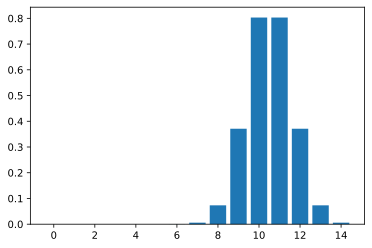

In [30]:
HL_gap = np.where(hf_tapered==0)[0][0]-.5
ham_biasing = ObservableBiasing(base_operator=ham_tap, HOMO_LUMO_gap=HL_gap)
sor_biasing = ObservableBiasing(base_operator=weight_op, HOMO_LUMO_gap=HL_gap)
CC_biasing  = ObservableBiasing(base_operator=ucc_tap, HOMO_LUMO_gap=HL_gap)

ham_biasing.HOMO_bias  = 0.5
ham_biasing.LUMO_bias  = 0.5
ham_biasing.separation = 1

print(f'The HOMO-LUMO gap lies between spin-orbitals {int(HL_gap-1/2)} and {int(HL_gap+1/2)}')
plt.bar(np.arange(ham_tap.n_qubits),ham_biasing.HOMO_LUMO_bias_curve())

In [32]:
%%timeit

ham_biasing.HOMO_bias  = 0.2
ham_biasing.LUMO_bias  = 0.2
q=ham_tap.n_qubits//2
H_bias_tap = sor_biasing.HOMO_LUMO_biased_operator()
#H_bias_tap = taper_hamiltonian.taper_it(
#    aux_operator= H_bias, 
#    ref_state=hf_array
#)
stabilizers = StabilizerIdentification(H_bias_tap)
S = stabilizers.symmetry_basis_by_subspace_dimension(n_sim_qubits=q)
stab_score = cs_vqe.basis_score(S)

33.3 ms ± 2.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [33]:
heatmap_data={}
steps=10

avg_single = 33.3#ms
runtime_prediction = (avg_single/1000 * steps**2 * (ham_tap.n_qubits-1))/60
print(f'Predicted runtime: {runtime_prediction: .1f} minutes')
print()

for q in range(1, ham_tap.n_qubits):
    print(f'{q}-qubit')
    qubit_data = []
    for a in np.linspace(0, 1, steps):
        for b in np.linspace(0, 1, steps):
            sor_biasing.HOMO_bias = a
            sor_biasing.LUMO_bias = b
            H_bias = sor_biasing.HOMO_LUMO_biased_operator()
            #H_bias_tap = taper_hamiltonian.taper_it(
            #    aux_operator= H_bias, 
            #    ref_state=hf_array
            #)
            stabilizers = StabilizerIdentification(H_bias)
            S = stabilizers.symmetry_basis_by_subspace_dimension(n_sim_qubits=q)
            stab_score = cs_vqe.basis_score(S)
            #ham_cs = cs_vqe_lw.project_onto_subspace(S)
            #matrix = ham_cs.to_sparse_matrix
            #e = exact_gs_energy(matrix)[0]
            #error = e-molecule.fci_energy

            qubit_data.append((a,b,stab_score))#,error))
        heatmap_data[q] = qubit_data

Predicted runtime:  0.8 minutes

1-qubit
2-qubit
3-qubit
4-qubit
5-qubit
6-qubit
7-qubit
8-qubit
9-qubit
10-qubit
11-qubit
12-qubit
13-qubit
14-qubit


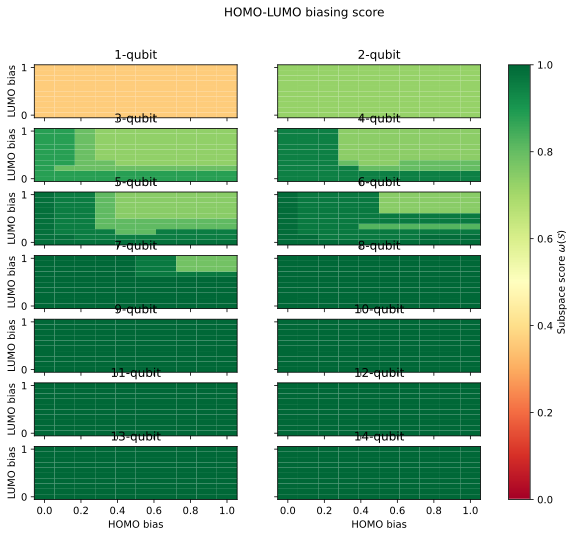

In [34]:
def factor_near_square(x: int):
    a = int(np.sqrt(x))
    b = x/a
    while b-int(b)!=0:
        a+=1
        b = x/a
    return int(a),int(b)

n_rows,n_cols=factor_near_square(ham_tap.n_qubits-1)

fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, sharey=True, sharex=True, figsize=(10,8))

for q, data in list(heatmap_data.items()):
    i, j=(q-1)//n_cols, (q-1)%n_cols
    # generate 2 2d grids for the x & y bounds
    x,y,z_score = zip(*data)
    x = np.array(x).reshape(steps,steps)
    y = np.array(y).reshape(steps,steps)
    z_score = np.array(z_score).reshape(steps,steps)
    #z_error = np.array(z_error).reshape(steps,steps)
    
    c = axes[i, j].pcolormesh(
        x, y, z_score, cmap='RdYlGn', 
        vmin=0, vmax=1, shading='auto'
    )
    axes[i, j].set_title(f'{q}-qubit')
    # set the limits of the plot to the limits of the data
    #axes[i, j].axis([x.min(), x.max(), y.min(), y.max()])
    if i==n_rows-1:
        axes[i, j].set_xlabel('HOMO bias')
    if j==0:
        axes[i, j].set_ylabel('LUMO bias')

fig.colorbar(c, ax=axes, label='Subspace score $\omega(\mathcal{S})$')
fig.suptitle('HOMO-LUMO biasing score')
plt.show()

In [ ]:
from scipy.optimize import minimize, differential_evolution, shgo, basinhopping, dual_annealing

def stabilizer_walk(n_sim_qubits, biasing_operator: ObservableBiasing):
    
    def get_stabilizers(x):
        biasing_operator.HOMO_bias,biasing_operator.LUMO_bias = x
        biased_op = biasing_operator.HOMO_LUMO_biased_operator()
        #biased_op = taper_hamiltonian.taper_it(aux_operator=biased_op, ref_state=hf_array)
        stabilizers = StabilizerIdentification(biased_op)
        S = stabilizers.symmetry_basis_by_subspace_dimension(n_sim_qubits)
        return(S)
    
    def objective(x):
        S = get_stabilizers(x)
        stab_score = cs_vqe_lw.basis_score(S)
        return -stab_score
    
    opt_out = differential_evolution(objective, x0=[.5,.5], bounds=[(0,1),(0,1)])
    stab_score=-opt_out['fun']
    bias_param=opt_out['x']
    print(f'Optimal score w(S)={stab_score} for HOMO/LUMO bias {bias_param}')
    S=get_stabilizers(bias_param)
    return S

HL_gap = np.where(hf_array==0)[0][0]-.5
ham_biasing = ObservableBiasing(base_operator=sor_tap, HOMO_LUMO_gap=HL_gap)
S_HL = stabilizer_walk(7, ham_biasing)

In [ ]:
#from symred.projection import stabilizer_walk

HL_gap = np.where(hf_tapered==0)[0][0]-.5
ham_biasing = ObservableBiasing(base_operator=ham_tap , HOMO_LUMO_gap=HL_gap)

scores = []

for i in range(1, ham_tap.n_qubits):
    print(i)
    ham_stabilizers = StabilizerIdentification(sor_tap)
    S_ham        = ham_stabilizers.symmetry_basis_by_subspace_dimension(i)
    S_ham_biased = stabilizer_walk(
        n_sim_qubits=i, 
        biasing_operator=ham_biasing, 
        #cs_vqe_object=cs_vqe_lw,
        #tapering_object=taper_hamiltonian,
        #reference_state=hf_array
    )
    
    stab_score_ham = cs_vqe_lw.basis_score(S_ham)
    stab_score_ham_biased = cs_vqe_lw.basis_score(S_ham_biased)
    
    if i <=10:
        ham_cs = cs_vqe_lw.project_onto_subspace(S_ham)
        matrix = ham_cs.to_sparse_matrix
        e = exact_gs_energy(matrix)[0]
        error = e-molecule.fci_energy

        ham_cs = cs_vqe_lw.project_onto_subspace(S_ham_biased)
        matrix = ham_cs.to_sparse_matrix
        e = exact_gs_energy(matrix)[0]
        error_biased = e-molecule.fci_energy
    else:
        error = None
        error_biased = None
        
    scores.append((stab_score_ham, stab_score_ham_biased, error, error_biased))

In [ ]:
fig,energy_axis = plt.subplots()
X = np.arange(1, ham_tap.n_qubits)
Y_ham,Y_ham_biased,Y_error,Y_error_biased = zip(*scores)

energy_axis.plot(X, Y_error, color='black', marker='+', label='Ground state energy')
energy_axis.plot(X, Y_error_biased, color='black', marker='+', label='Biased ground state energy', ls='--')
energy_axis.hlines(molecule.hf_energy-molecule.fci_energy, 1, X[-1], ls='--', color='red', label='HF energy')
energy_axis.hlines(molecule.mp2_energy-molecule.fci_energy, 1, X[-1], ls='--', color='orange', label='MP2 energy')
energy_axis.hlines(molecule.ccsd_energy-molecule.fci_energy, 1, X[-1], ls='--', color='green', label='CCSD energy')
energy_axis.hlines(0.0016, 1, X[-1], ls='--', color='black', label='Chemical accuracy')

energy_axis.set_yscale('log')

score_axis = energy_axis.twinx()
score_axis.plot(X, Y_ham, color='green', label='Hamiltonian', alpha=0.5)
score_axis.plot(X, Y_ham_biased, color='green', label='Biased hamiltonian', alpha=0.5, ls='--')

energy_axis.legend(ncol=1, bbox_to_anchor=(1.52,1))
score_axis.legend(ncol=1, bbox_to_anchor=(1.5,0.3))
plt.show()

In [ ]:
X_block = molecule.T_q.X_block
X_op = PauliwordOp(
    np.hstack([X_block, np.zeros_like(X_block)]), 
    np.abs(molecule.T_q.coeff_vec)
).cleanup()
#X_op.coeff_vec = np.sum(X_op.X_block*CC_biasing.HOMO_LUMO_bias_curve(), axis=1)*X_op.coeff_vec
X_op

In [ ]:
biased_op==X_op

In [ ]:
CC_biasing.HOMO_bias,CC_biasing.LUMO_bias = 0,0
biased_op = CC_biasing.HOMO_LUMO_biased_operator()
biased_op_tap = taper_hamiltonian.taper_it(aux_operator=biased_op, ref_state=hf_array)
stabilizers = StabilizerIdentification(biased_op_tap)
S = stabilizers.symmetry_basis_by_subspace_dimension(6)
S

In [ ]:
X_op_tap = taper_hamiltonian.taper_it(aux_operator=X_op, ref_state=hf_array)
CC_stabilizers = StabilizerIdentification(X_op_tap)
S_CC         = CC_stabilizers.symmetry_basis_by_subspace_dimension(6)
print(S_CC)
print()
S_CC_biased  = stabilizer_walk(6, CC_biasing)
print(S_CC_biased)
stab_score_CC_biased  = cs_vqe_lw.basis_score(S_CC_biased)

ham_cs = cs_vqe_lw.project_onto_subspace(S_CC)
print(ham_cs.n_qubits)
matrix = ham_cs.to_sparse_matrix
e = exact_gs_energy(matrix)[0]
error = e-molecule.fci_energy
error

In [ ]:
def factor_near_square(x: int):
    a = int(np.sqrt(x))
    b = x/a
    while b-int(b)!=0:
        a+=1
        b = x/a
    return int(a),int(b)

n_rows,n_cols=factor_near_square(ham_tap.n_qubits-1)

fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, sharey=True, sharex=True, figsize=(10,8))

for q, data in heatmap_data.items():
    i, j=(q-1)//n_cols, (q-1)%n_cols
    # generate 2 2d grids for the x & y bounds
    x,y,z_score,z_error = zip(*data)
    x = np.array(x).reshape(steps,steps)
    y = np.array(y).reshape(steps,steps)
    #z_score = np.array(z_score).reshape(steps,steps)
    z_error = np.array(z_error).reshape(steps,steps)
    
    c = axes[i, j].pcolormesh(
        x, y, z_error*1000, cmap='RdYlGn_r', 
        vmin=0, vmax=(molecule.hf_energy-molecule.fci_energy)*1000, shading='auto'
    )
    axes[i, j].set_title(f'{q}-qubit')
    # set the limits of the plot to the limits of the data
    #axes[i, j].axis([x.min(), x.max(), y.min(), y.max()])
    if i==n_rows-1:
        axes[i, j].set_xlabel('LUMO bias')
    if j==0:
        axes[i, j].set_ylabel('HOMO bias')

fig.colorbar(c, ax=axes, label='Absolute error [mHa]')
fig.suptitle('HOMO-LUMO biasing error')
plt.show()

In [ ]:
# generate 2 2d grids for the x & y bounds
x,y,z_score,z_error = zip(*heatmap_data)
x = np.array(x).reshape(steps,steps)
y = np.array(y).reshape(steps,steps)
z_score = np.array(z_score).reshape(steps,steps)
z_error = np.array(z_error).reshape(steps,steps)

In [ ]:
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z_error, cmap='RdYlGn_r', vmin=0, vmax=z_error.max())
ax.set_title('Hamiltonian HOMO-LUMO biasing error')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
ax.set_xlabel('LUMO bias')
ax.set_ylabel('HOMO bias')
fig.colorbar(c, ax=ax)
plt.show()

In [ ]:
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z_score, cmap='RdYlGn', vmin=0, vmax=1)
ax.set_title('Hamiltonian HOMO-LUMO biasing score')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
ax.set_xlabel('LUMO bias')
ax.set_ylabel('HOMO bias')
fig.colorbar(c, ax=ax)
plt.show()

In [ ]:
from scipy.optimize import minimize

def stabilizer_search(n_sim_qubits):
    
    def get_stabilizers(x):
        ham_biasing.HOMO_bias = x
        ham_biasing.LUMO_bias = x
        H_bias = taper_hamiltonian.taper_it(aux_operator=ham_biasing.HOMO_LUMO_biased_operator(), ref_state=hf_array)
        stabilizers = StabilizerIdentification(H_bias)
        S = stabilizers.symmetry_basis_by_subspace_dimension(n_sim_qubits)
        return(S)
    
    def objective(x):
        S = get_stabilizers(x)
        stab_score = cs_vqe_lw.basis_score(S)
        return -stab_score
    
    opt_out = minimize(objective, x0=[0], bounds=[(0,1)], method='POWELL')
    stab_score=-opt_out['fun']
    print(f'Optimal score w(S)={stab_score}')
    S=get_stabilizers(*opt_out['x'])
    return S

#plt.plot(bias_curve(np.arange(ham_tap.n_qubits), u_sig=np.pi/2, l_sig=np.pi/2,sep=10))
#stabs = stabilizer_search(20)
#print(stabs)

#ham_cs = cs_vqe_lw.project_onto_subspace(stabs)
#matrix = ham_cs.to_sparse_matrix
#e = exact_gs_energy(matrix)[0]
#error = e-fci_energy

#print(f'Energy error wrt FCI is {error} Ha')

In [ ]:
scores = []

for i in range(1, ham_tap.n_qubits):
    print(i)
    S = stabilizer_search(i)
    stab_score = cs_vqe_lw.basis_score(S)
    scores.append(stab_score)

In [ ]:
plt.plot(scores)
plt.hlines(1, 0, ham_tap.n_qubits)

In [ ]:
ref_energy = fci_energy
max_sim_q = 10

scores = []
energy = []

for i in range(1, ham_tap.n_qubits):
    try:
        stabilizers =  find_stabilizers(n_sim_qubits=i, region=[0,hlg_sort.n_terms])
        stab_score = cs_vqe_lw.basis_score(stabilizers)
        scores.append(stab_score)
        print('Basis score (min:0, max:1):', stab_score)
        if i<=max_sim_q:
            ham_cs = cs_vqe_lw.project_onto_subspace(stabilizers)
            print(f'Number of qubits in contextual subspace: {ham_cs.n_qubits}/{ham_tap.n_qubits}')
            matrix = ham_cs.to_sparse_matrix
            e = exact_gs_energy(matrix)[0]
            print('Error from CCSD:', e-ref_energy)
            energy.append(e)
    except:
        print(i, 'did not work')

In [ ]:
from matplotlib import pyplot as plt
#plt.style.use('ggplot')

fig,energy_axis = plt.subplots()
X=np.arange(1, ham_tap.n_qubits)

Y_energy=np.array(energy)-ref_energy
energy_axis.plot(X[:max_sim_q], Y_energy, color='black')
energy_axis.hlines(hf_energy-ref_energy, 1, X[-1], ls='--', color='red', label='HF energy')
energy_axis.hlines(mp2_energy-ref_energy, 1, X[-1], ls='--', color='orange', label='MP2 energy')
energy_axis.hlines(ccsd_energy-ref_energy, 1, X[-1], ls='--', color='green', label='CCSD energy')
energy_axis.hlines(0.0016, 1, X[-1], ls='--', color='black', label='Chemical accuracy')

#energy_axis.set_ylim(1e-15, 1e-0) 
#energy_axis.set_yscale('log')

score_axis = energy_axis.twinx()
Y_scores=np.array(scores)
score_axis.scatter(X, Y_scores, color='black', marker='+')

#energy_axis.set_xticks(X)

fig.legend(ncol=4)
plt.show()

In [ ]:
#with open('data/score_data.json', 'r') as infile:
#    scoring_data = json.load(infile)
    
#scoring_data

In [ ]:
#speciesname = 'H2O_6-31g_SINGLET'

#scoring_data[speciesname] = {
#    'n_qubits_pre_taper': H_q.n_qubits, 
#    'n_qubits_post_taper': ham_tap.n_qubits,
#    'hf_energy': hf_energy,
#    'mp2_energy': mp2_energy,
#    'ccsd_energy': ccsd_energy,
#    'fci_energy': fci_energy,
#    'cs_vqe_energies': energy,
#    'stabilizer_score': scores
#}

#scoring_data

In [ ]:
#with open('data/score_data.json', 'w') as outfile:
#    json.dump(scoring_data, outfile)

In [ ]:
from scipy.special import comb

def random_stabs(n_stabs):
    Z_block = np.random.randint(0,2,(n_stabs, ham_tap.n_qubits))
    S = StabilizerOp(np.hstack([np.zeros_like(Z_block), Z_block]), np.ones(n_stabs))
    return S

def score_vs_energy(n_stabs):
    S = random_stabs(n_stabs)
    ucc_stab_score = cs_vqe_lw.basis_score(S)
    ham_stab_score = cs_vqe_lw_2.basis_score(S)
    ham_cs = cs_vqe_lw.project_onto_subspace(S)
    matrix = ham_cs.to_sparse_matrix
    e = exact_gs_energy(matrix)[0]
    return ham_stab_score, ucc_stab_score, e

data={}

for n_stabs in range(1, ham_tap.n_qubits):
    print(f'Randomizing {n_stabs} stabilizer(s)')
    count=0
    results = []
    while count<=2**ham_tap.n_qubits:
        try:
            results.append(score_vs_energy(n_stabs))
            count+=1
        except:
            pass
    data[ham_tap.n_qubits-n_stabs] = results

Randomizing 1 stabilizer(s)


In [ ]:
from matplotlib.pyplot import Normalize

fig,axis = plt.subplots()

increments = []

for n_qubits,results in data.items():
    ratio = n_qubits/ham_tap.n_qubits
    increments.append(ratio)
    c = plt.cm.jet(ratio)
    X_ham, X_ucc, Y = zip(*results)
    X = np.array(X_ucc)
    Y = np.array(Y) - fci_energy
    axis.scatter(
        X, 
        Y, 
        marker='+', 
        color=c, 
        zorder=1,#n_qubits,
        alpha=0.9)
    
keys = list(data.keys())
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(), cmap='jet'), 
                     ax=axis, label='# qubits in stabilizer subspace', ticks=increments)#, fraction=0.78)
cbar.ax.set_yticklabels(keys)

axis.set_xlabel('Stabilizer subspace score')
axis.set_ylabel('$\omega(\mathcal{S})$')

axis.hlines(hf_energy-fci_energy, 0, 1, ls='--', lw=1, color='red', zorder=0, label='HF energy')
axis.hlines(mp2_energy-fci_energy, 0, 1, ls='--', lw=1, color='orange', zorder=0, label='MP2 energy')
axis.hlines(ccsd_energy-fci_energy, 0, 1, ls='--', lw=1, color='green', zorder=0, label='CCSD energy')
axis.hlines(0.0016, 0, 1, ls='--', lw=1, color='black', zorder=0, label='Chemical accuracy')

fig.legend(ncol=2, bbox_to_anchor=(0.7,0))

In [ ]:
#with open('data/score_vs_energy.json', 'r') as infile:
#    score_vs_energy = json.load(infile)
#    
#score_vs_energy.keys()

In [ ]:
#score_vs_energy[speciesname] = {
#    'n_qubits_pre_taper': H_q.n_qubits, 
#    'n_qubits_post_taper': ham_tap.n_qubits,
#    'hf_energy': hf_energy,
#    'mp2_energy': mp2_energy,
#    'ccsd_energy': ccsd_energy,
#    'fci_energy': fci_energy,
#    'ham_score_ucc_score_cs_energy':data
#}
#score_vs_energy

In [ ]:
#with open('data/score_vs_energy.json', 'w') as outfile:
#    json.dump(score_vs_energy, outfile)